# FX data retrieval

Steps: 

1. Load 1-Minute data from https://github.com/philipperemy/FX-1-Minute-Data (there is a link to Google Disk)
2. Extract all CSV-s from zip files
3. Create one dataframe, pivot and clean it
4. Save to parquet

In [107]:
import glob
import pandas as pd
import numpy as np
import zipfile

from tqdm import tqdm

## Raw data extraction

In [83]:
datafolder = "C:/Users/Ivan/Downloads/"

In [119]:
list_of_files = glob.glob(f"{datafolder}*.zip")

In [120]:
list_of_files

['C:/Users/Ivan/Downloads\\eurjpy-20260128T175233Z-3-001.zip',
 'C:/Users/Ivan/Downloads\\eurusd-20260128T175054Z-3-001.zip',
 'C:/Users/Ivan/Downloads\\sgdjpy-20260128T175337Z-3-001.zip',
 'C:/Users/Ivan/Downloads\\usdjpy-20260128T175245Z-3-001.zip',
 'C:/Users/Ivan/Downloads\\usdsgd-20260128T182254Z-3-001.zip']

In [121]:
raw_results = []

for file in tqdm(list_of_files):

    upper_layer = zipfile.ZipFile(file)
    ccy = file.split("\\")[1][:6]

    for inner_file in upper_layer.namelist():

        inner_file = zipfile.ZipFile(upper_layer.extract(inner_file))

        for innermost_file in inner_file.namelist():

            if innermost_file[-3:] == "csv":
                temp = pd.read_csv(
                    inner_file.extract(innermost_file), sep=";", header=None
                )
                temp.columns = ["timestamp", "open", "high", "low", "close", "volume"]
                temp["ccy"] = ccy
                raw_results.append(temp[["timestamp", "close", "ccy"]].copy())

        inner_file.close()

    upper_layer.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:58<00:00, 11.66s/it]


## Data cleaning

In [122]:
results_df = pd.concat(raw_results, ignore_index=True)

In [123]:
%%time
results_df["timestamp"] = pd.to_datetime(
    results_df["timestamp"], format="%Y%m%d %H%M%S"
)

CPU times: total: 1min 51s
Wall time: 1min 51s


In [124]:
results_df = pd.pivot_table(
    data=results_df, index="timestamp", columns="ccy", values="close"
)

In [125]:
results_df = results_df["2010-01-01":]

Leaving workdays and trading hours only

In [134]:
results_df = results_df.loc[results_df.index.weekday <= 4, :]

FX is OTC traded, so lets assume that trading hours are 9.00 - 19.00

In [139]:
results_df = results_df.loc[
    (results_df.index.hour < 19) & (results_df.index.hour >= 9), :
]

### Percentage of empty data

Per ccy pair

In [140]:
pd.isna(results_df).sum(axis=0) / pd.isna(results_df).shape[0]

ccy
eurjpy    0.020380
eurusd    0.025588
sgdjpy    0.045617
usdjpy    0.043029
usdsgd    0.153231
hour      0.000000
dtype: float64

Per hour

All times are reported in the same timezone (as said in the source)

In [141]:
results_df = results_df.assign(hour=results_df.index.hour)

C:\Users\Ivan\AppData\Local\Temp\ipykernel_9176\1338268326.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.sum(pd.isna(x), axis=0) / x.shape[0])


<Axes: xlabel='hour'>

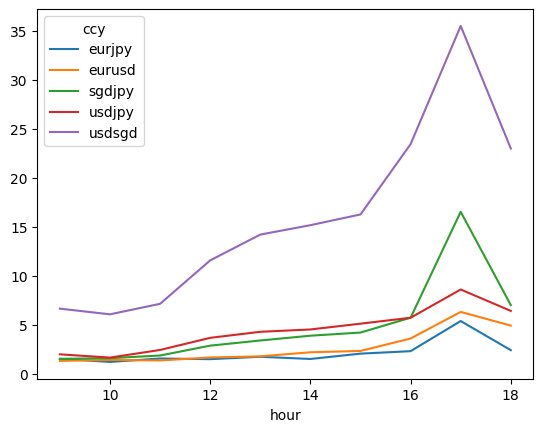

In [142]:
missing_data = (
    results_df.groupby("hour")
    .apply(lambda x: np.sum(pd.isna(x), axis=0) / x.shape[0])
    .drop(columns=["hour"])
    .div(1e-2)
)

missing_data.plot()

Lets assume that if value is missing than the price was the same for simplicity

In [146]:
results_df = results_df.sort_index().ffill()

In [151]:
results_df.head()

ccy,eurjpy,eurusd,sgdjpy,usdjpy,usdsgd,hour
timestamp,,,,,,
2010-01-04 09:00:00,133.65,1.4430,66.22,92.63,1.3983,9
2010-01-04 09:01:00,133.64,1.4428,66.23,92.64,1.3983,9
2010-01-04 09:02:00,133.65,1.4427,66.24,92.64,1.3982,9
2010-01-04 09:03:00,133.67,1.4431,66.24,92.64,1.3982,9
2010-01-04 09:04:00,133.71,1.4439,66.22,92.62,1.3981,9


In [153]:
(
    results_df.drop(columns=["hour"]).to_parquet(
        "FX_data.parquet.gzip", compression="gzip"
    )
)